In [138]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error as m_a_e, mean_squared_error as m_s_e, r2_score as r2
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lime import lime_tabular

from scipy.stats.mstats import winsorize

In [139]:
import warnings
warnings.filterwarnings('ignore')

In [140]:
dataset = "E:/Formation Data Scientist/Projet_4/2016_Building_Energy_Benchmarking.csv"

In [141]:
df = pd.read_csv(dataset)

### <a name='C2'> EDA et Choix des features   </a>

In [142]:
df.head(3)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [144]:
df.shape

(3376, 46)

- Exploration des valeurs nulles

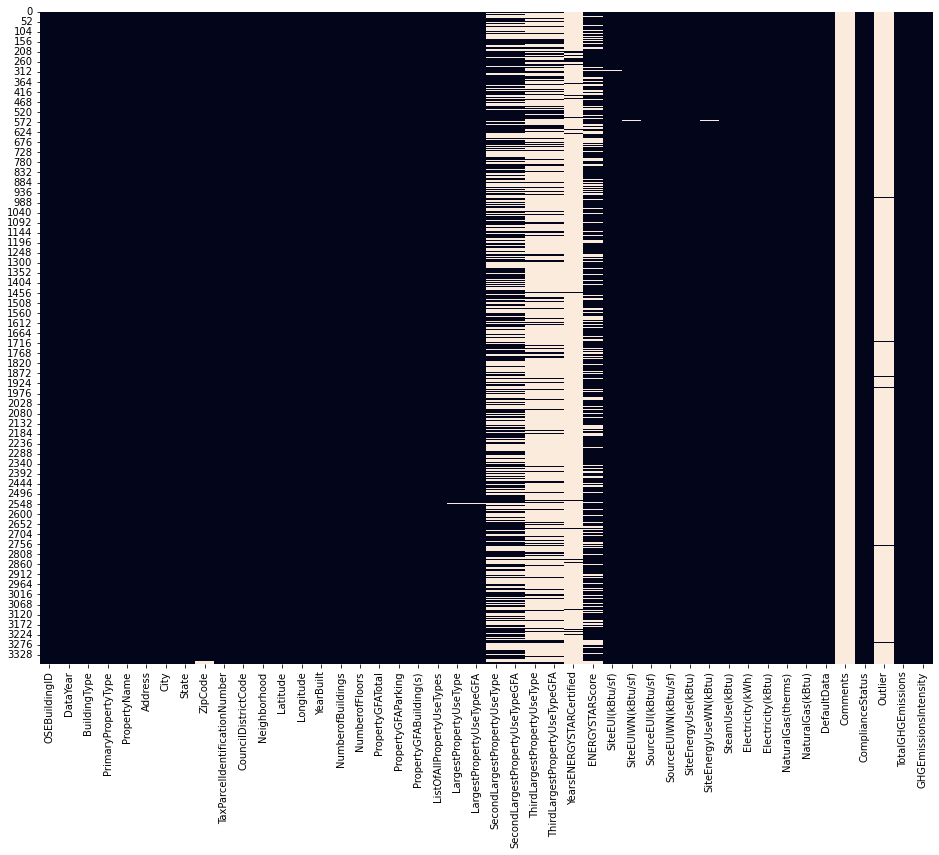

In [145]:
plt.figure(figsize=(16,12))
sns.heatmap(df.isna(),cbar=False)
plt.show()

- Typologie des variables

In [146]:
df.dtypes.value_counts()

float64    22
object     15
int64       8
bool        1
dtype: int64

- Nombre de variables différentes par Feature

In [147]:
df.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [148]:
df['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [149]:
df['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

On a 8 types de buiding, seuls les buildings résidentiels nous interressent dans le cadre de notre étude

In [150]:
df.iloc[:,2].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

Ici ce sont les buildings de type Multifamily qui nous interressent (rajouter Campus??)

In [151]:
df.iloc[:,3].value_counts()

Low-Rise Multifamily           987
Mid-Rise Multifamily           564
Small- and Mid-Sized Office    293
Other                          256
Warehouse                      187
Large Office                   173
K-12 School                    139
Mixed Use Property             133
High-Rise Multifamily          105
Retail Store                    91
Hotel                           77
Worship Facility                71
Distribution Center             53
Senior Care Community           45
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
University                      25
Residence Hall                  23
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Office                           3
Name: PrimaryPropertyType, dtype: int64

- Nombre de valeures nulles par feature

In [152]:
df.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                              16
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     8
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             9
LargestPropertyUseType               20
LargestPropertyUseTypeGFA            20
SecondLargestPropertyUseType       1697
SecondLargestPropertyUseTypeGFA    1697


### <a name='C2'> Feature Engineering   </a>

In [307]:
building_type = ['NonResidential','NonResidential COS','NonResidential WA','Campus','SPS-District K-12'] 

nonRes = df[df['BuildingType'].isin(building_type)].reset_index(drop=True)

- Nos deux targets sont **TotalGHGEmissions** et **SiteEnergyUse(kBtu)**

In [308]:
compliant = ['Compliant']

nonRes = nonRes[nonRes['ComplianceStatus'].isin(compliant)].reset_index(drop=True)

In [309]:
nonRes.shape

(1466, 46)

In [310]:
nonRes.head(1)

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1156514.25,3946027.0,12764.5293,1276453.0,False,NaN,Compliant,NaN,249.98,2.83


In [311]:
#nonRes[nonRes['BuildingType'] == 'Campus']

In [312]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Other                          190
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Residence Hall                  21
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             2
Name: PrimaryPropertyType, dtype: int64

- Nettoyage et choix des features à utiliser

In [313]:
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Low-Rise Multifamily'].index)
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Residence Hall'].index)
nonRes = nonRes.drop(nonRes[nonRes['PrimaryPropertyType'] == 'Other'].index)

In [314]:
nonRes.iloc[:,3].value_counts()

Small- and Mid-Sized Office    282
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      23
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [315]:
nonRes.isna().sum()

OSEBuildingID                         0
DataYear                              0
BuildingType                          0
PrimaryPropertyType                   0
PropertyName                          0
Address                               0
City                                  0
State                                 0
ZipCode                               0
TaxParcelIdentificationNumber         0
CouncilDistrictCode                   0
Neighborhood                          0
Latitude                              0
Longitude                             0
YearBuilt                             0
NumberofBuildings                     0
NumberofFloors                        0
PropertyGFATotal                      0
PropertyGFAParking                    0
PropertyGFABuilding(s)                0
ListOfAllPropertyUseTypes             0
LargestPropertyUseType                4
LargestPropertyUseTypeGFA             4
SecondLargestPropertyUseType        552
SecondLargestPropertyUseTypeGFA     552


In [316]:
nonRes['ComplianceStatus'].value_counts()

Compliant    1253
Name: ComplianceStatus, dtype: int64

In [317]:
nonRes['Outlier'].value_counts()

Series([], Name: Outlier, dtype: int64)

In [318]:
nonRes = nonRes[nonRes.Outlier.isnull()]

In [319]:
nonResidential = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','SiteEnergyUse(kBtu)']]

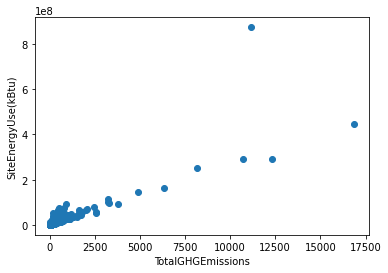

In [320]:
plt.scatter(nonResidential['TotalGHGEmissions'],nonResidential['SiteEnergyUse(kBtu)'])
plt.xlabel('TotalGHGEmissions')
plt.ylabel('SiteEnergyUse(kBtu)')
plt.show()

In [321]:
nonResidential[nonResidential['SiteEnergyUse(kBtu)'] > 600000000]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
1443,University,47.65644,-122.31041,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


- Drop des Outliers

In [322]:
nonResidential[nonResidential['TotalGHGEmissions'] > 10000]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
28,Mixed Use Property,47.534930,-122.317880,1992,1.0,3,494835,0,757027.0,0.0,150476283.0,297909000.0,16870.98,448385312.0
117,Hospital,47.603990,-122.323770,2000,9.0,8,1158691,0,1350182.0,122575032.0,168683602.0,1832129.0,10734.57,293090784.0
532,Hospital,47.608951,-122.322402,1994,7.0,14,1765970,0,1639334.0,134943456.0,139354828.0,17316120.0,12307.16,291614432.0
1443,University,47.656440,-122.310410,1900,111.0,0,9320156,0,9320156.0,84985240.0,657074389.0,0.0,11140.56,873923712.0


In [323]:
# suppression des valeurs GHGE > 10000
#nonResidential = nonResidential[nonResidential['TotalGHGEmissions'] < 10000]

In [324]:
# suppression des valeurs energy > 600000000
nonResidential = nonResidential[nonResidential['SiteEnergyUse(kBtu)'] < 600000000]

In [325]:
nonResidential.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    4
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
SiteEnergyUse(kBtu)          0
dtype: int64

In [326]:
nonResidential[nonResidential['LargestPropertyUseTypeGFA'].isna()]

,PrimaryPropertyType,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),PropertyGFAParking,LargestPropertyUseTypeGFA,SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,SiteEnergyUse(kBtu)
281,Self-Storage Facility,47.66838,-122.39310,1946,2.0,2,111445,0,NaN,0.0,3007514.0,2689958.0,163.83,5.697472e+06
726,Hotel,47.61203,-122.34165,1910,1.0,8,61721,0,NaN,0.0,2534592.0,362488.0,36.92,2.897080e+06
1201,Small- and Mid-Sized Office,47.64747,-122.34086,2008,1.0,4,48350,0,NaN,0.0,3168131.0,0.0,22.09,3.168131e+06
1217,Restaurant,47.59697,-122.32474,1913,1.0,3,28800,0,NaN,0.0,402907.0,497017.0,29.21,8.999242e+05


In [327]:
nonResidential['PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    282
Warehouse                      178
Large Office                   165
Mixed Use Property             105
Retail Store                    85
Hotel                           75
Worship Facility                69
Distribution Center             51
K-12 School                     50
Supermarket / Grocery Store     40
Medical Office                  38
Self-Storage Facility           28
University                      22
Senior Care Community           20
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Name: PrimaryPropertyType, dtype: int64

In [328]:
nonResidential = nonResidential.dropna(axis=0) 

In [329]:
nonResidential['NumberofBuildings'].value_counts()

1.0     1181
0.0       37
2.0        9
3.0        6
4.0        3
6.0        3
14.0       2
5.0        2
27.0       1
11.0       1
9.0        1
7.0        1
8.0        1
Name: NumberofBuildings, dtype: int64

- Calcul de l'age des batiments

In [330]:
df1 = nonResidential.copy()

In [331]:
def fill_date(data):
    if data<= 1920:
        return "_1920"
    elif 1920<data<=1940:
        return "1920_1940"
    elif 1940<data<=1960:
        return "1940_1960"
    elif 1960<data<=1980:
        return "1960_1980"
    elif 1980<data<=2000:
        return "1980_2000"
    elif data>2000:
        return "2000_"

In [332]:
df1['YearBuilt'] = df1['YearBuilt'].apply(fill_date)

In [333]:
df1['SteamUse(kBtu)'] = df1['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['Electricity(kBtu)'] = df1['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
df1['NaturalGas(kBtu)'] = df1['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [334]:
df2_code = pd.get_dummies(df1 ,columns=['PrimaryPropertyType','YearBuilt'])

In [335]:
train, test = train_test_split(df2_code, test_size=0.3, random_state=0) 

In [336]:
X_train, y1_train, X_test, y1_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["TotalGHGEmissions"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["TotalGHGEmissions"]
X_train, y2_train, X_test, y2_test = train.drop(columns = ["TotalGHGEmissions","SiteEnergyUse(kBtu)"]), train["SiteEnergyUse(kBtu)"],test.drop(columns = ["TotalGHGEmissions",'SiteEnergyUse(kBtu)']) ,test["SiteEnergyUse(kBtu)"]

### <a name='C2'> Prédictions de TotalGHGEmissions   </a>

In [337]:
r_forest = RandomForestRegressor(random_state=0)

In [338]:
# entrainement du modèle
r_forest.fit(X_train, y1_train)

RandomForestRegressor(random_state=0)

In [339]:
# prédiction
preds = r_forest.predict(X_test)

# calcul du RMSE
print(m_s_e(y1_test,preds, squared=False))

349.35056711095416


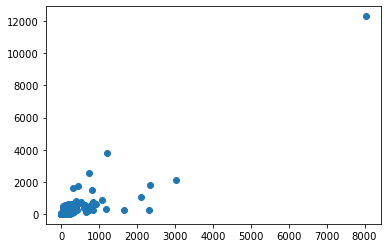

In [340]:
plt.scatter(preds,y1_test)

In [341]:
def get_error(n_estimator, X_train, X_test, y_train, y_test):
    model = RandomForestRegressor(n_estimators=n_estimator, random_state=0)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [342]:
def get_dummy_error(strategy, X_train, X_test, y_train, y_test):
    model = DummyRegressor(strategy=strategy)
    model.fit(X_train, y_train)
    preds_val = model.predict(X_test)
    rmse = m_s_e(y_test, preds_val,squared=False)
    mae = m_a_e(y_test, preds_val)
    r_2 = r2(y_test,preds_val)
    return(rmse, mae, r_2)

In [343]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for strategy in ['mean', 'median']:
    my_rmse = get_dummy_error(strategy, X_train, X_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("strategy: %s  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(strategy, my_rmse[0], my_rmse[1], my_rmse[2]))

strategy: mean  		 RMSE:  709.615859  		 MAE: 217.192231  		 R2:  -0.000171
strategy: median  		 RMSE:  722.267294  		 MAE: 160.996640  		 R2:  -0.036152


In [344]:
# comparer RMSE et r2 avec differents valeurs de n_estimator
lst_rmse = []
lst_mae = []
lst_r2 = []
for n_estimator in [100, 200, 300, 400, 500]:
    my_rmse = get_error(n_estimator, X_train, X_test, y1_train, y1_test)
    lst_rmse.append(my_rmse[0])
    lst_mae.append(my_rmse[1])
    lst_r2.append(my_rmse[2])
    print("N_Estimator: %d  \t\t RMSE:  %f  \t\t MAE: %f  \t\t R2:  %f" %(n_estimator, my_rmse[0], my_rmse[1], my_rmse[2]))

N_Estimator: 100  		 RMSE:  349.350567  		 MAE: 110.412561  		 R2:  0.757590
N_Estimator: 200  		 RMSE:  343.488144  		 MAE: 108.673535  		 R2:  0.765657
N_Estimator: 300  		 RMSE:  347.744377  		 MAE: 109.483335  		 R2:  0.759814
N_Estimator: 400  		 RMSE:  339.222208  		 MAE: 108.232433  		 R2:  0.771442
N_Estimator: 500  		 RMSE:  340.767848  		 MAE: 109.449622  		 R2:  0.769354


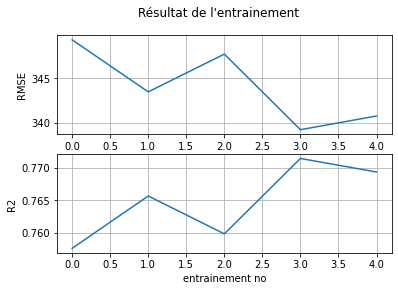

In [345]:
fig,(ax1,ax2) = plt.subplots(2,1)
fig.suptitle('Résultat de l\'entrainement')

ax1.plot(lst_rmse)
ax1.set_ylabel('RMSE')
ax1.set_xlabel('entrainement no')
ax1.grid()

ax2.plot(lst_r2)
ax2.set_ylabel('R2')
ax2.set_xlabel('entrainement no')
ax2.grid()

plt.show()

In [346]:
scores = []
best_scores = []

### - Dummy Regressor

In [347]:
dummy_param_grid = {'strategy' : ['mean','median']}

In [348]:
CV_dummy_mean = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_mean.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [349]:
CV_dummy_mean.best_score_

-0.021884142270444506

In [350]:
dummy_model = CV_dummy_mean.best_estimator_

In [351]:
dummy_model.score(X_test,y1_test)

-0.00017130173991253272

In [352]:
print(f"Score - training data: {round(CV_dummy_mean.score(X_train,y1_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_mean.score(X_test,y1_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.02 %


In [353]:
scores.append(dummy_model.score(X_test,y1_test))
best_scores.append(CV_dummy_mean.best_score_)

In [354]:
res_dummy = pd.DataFrame(CV_dummy_mean.cv_results_)

### - Random Forest Regressor


In [355]:
rfc_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [356]:
CV_rfc = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfc.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [357]:
CV_rfc.best_params_

{'max_depth': 8,
 'max_features': 'sqrt',
 'n_estimators': 300,
 'random_state': 12}

In [358]:
CV_rfc.best_score_

0.5180586538522316

In [359]:
rfc_model= CV_rfc.best_estimator_

In [360]:
rfc_model.score(X_test,y1_test)

0.7387428222624004

In [361]:
print(f"Score - training data: {round(CV_rfc.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_rfc.score(X_test,y1_test)*100,1)} %")

Score - training data: 88.1 %
Score - test data: 73.9 %


In [362]:
scores.append(rfc_model.score(X_test,y1_test))
best_scores.append(CV_rfc.best_score_)

In [363]:
res_forest = pd.DataFrame(CV_rfc.cv_results_)

### - Ridge Regressor

In [364]:
ridge_param_grid = {'alpha' : [1e-3, 1e-2, 1e-1, 1, 2, 5, 10],
              }

In [365]:
CV_ridge = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge.fit(X_train, y1_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [366]:
CV_ridge.best_score_

-2.400811043204986

In [367]:
model_ridge = CV_ridge.best_estimator_
print(model_ridge)

Ridge(alpha=0.001)


In [368]:
model_ridge.score(X_test,y1_test)

0.6398364662968836

In [369]:
print(f"Score - training data: {round(CV_ridge.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_ridge.score(X_test,y1_test)*100,1)} %")

Score - training data: 54.9 %
Score - test data: 64.0 %


In [370]:
scores.append(model_ridge.score(X_test,y1_test))
best_scores.append(CV_ridge.best_score_)

In [371]:
res_ridge = pd.DataFrame(CV_ridge.cv_results_)

### - KNN Regressor

In [372]:
knn_param_grid = {'n_neighbors' : list(range(10, 100)),
              }

In [373]:
CV_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 6,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn.fit(X_train, y1_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [374]:
CV_knn.best_score_

0.22313630074837096

In [375]:
model_knn = CV_knn.best_estimator_

In [376]:
model_knn.score(X_test,y1_test)

0.18055423032448614

In [377]:
print(f"Score - training data: {round(CV_knn.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn.score(X_test,y1_test)*100,1)} %")

Score - training data: 19.1 %
Score - test data: 18.1 %


In [378]:
scores.append(model_knn.score(X_test,y1_test))
best_scores.append(CV_knn.best_score_)

In [379]:
CV_knn.best_params_

{'n_neighbors': 68}

In [380]:
res_knn = pd.DataFrame(CV_knn.cv_results_)

### - XGBoost

In [381]:
xgboost_param_grid = {'n_estimators' : [100,200,300,400,500],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [4,5,6,7,8],
              'random_state': [12]}

In [382]:
CV_xgboost = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost.fit(X_train, y1_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [383]:
CV_xgboost.best_score_

0.537012029176452

In [384]:
model_boosted = CV_xgboost.best_estimator_

In [385]:
model_boosted.score(X_test,y1_test)

0.8271243204925245

In [386]:
y_pred = model_boosted.predict(X_test)

In [387]:
m_a_e(y1_test,y_pred)

108.85200979390075

In [388]:
r2(y1_test,y_pred)

0.8271243204925245

In [389]:
m_s_e(y1_test,y_pred,squared=False)

295.02109358776835

In [390]:
np.mean(y1_test)

181.5233866666667

In [391]:
CV_xgboost.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 100,
 'random_state': 12}

In [392]:
print(f"Score - training data: {round(CV_xgboost.score(X_train,y1_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost.score(X_test,y1_test)*100,1)} %")

Score - training data: 99.6 %
Score - test data: 82.7 %


In [393]:
model_boosted.feature_importances_

array([1.32041678e-01, 2.34907569e-02, 1.10618657e-01, 5.99265971e-02,
       1.02867817e-01, 8.02459815e-03, 2.92026011e-01, 1.77686629e-02,
       1.11736529e-05, 1.39020526e-02, 1.26331517e-04, 1.01132372e-01,
       3.93415220e-03, 3.64858738e-06, 4.09700084e-03, 4.80870564e-02,
       4.05849511e-03, 1.71291580e-02, 0.00000000e+00, 9.97806680e-05,
       3.11705309e-04, 1.08031633e-04, 5.25587228e-04, 2.08244104e-03,
       3.21938697e-03, 6.68661187e-04, 3.63828739e-04, 1.02710363e-04,
       2.08034755e-03, 5.11647794e-03, 3.77415427e-03, 3.25651212e-02,
       1.40201219e-03, 8.33353458e-03])

    Feature Importance                                     Feature Name
6             0.292026                        LargestPropertyUseTypeGFA
0             0.132042                                         Latitude
2             0.110619                                NumberofBuildings
4             0.102868                           PropertyGFABuilding(s)
11            0.101132                     PrimaryPropertyType_Hospital
3             0.059927                                   NumberofFloors
15            0.048087                 PrimaryPropertyType_Large Office
31            0.032565                              YearBuilt_1980_2000
1             0.023491                                        Longitude
7             0.017769                                   SteamUse(kBtu)
17            0.017129           PrimaryPropertyType_Mixed Use Property
9             0.013902                                 NaturalGas(kBtu)
33            0.008334                                  YearBuil

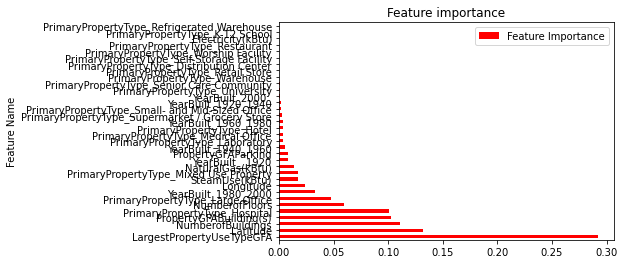

In [394]:
def display_feat_imp_xgboost(boosted):
  feat_imp = model_boosted.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = X_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(model_boosted)

In [395]:
scores.append(model_boosted.score(X_test,y1_test))
best_scores.append(CV_xgboost.best_score_)

In [396]:
res_xgboost = pd.DataFrame(CV_xgboost.cv_results_)

In [397]:
index = ['Dummy','Random Forest','Ridge','KNN','XGBoost']
columns = ['test score']
columns_b = ['validation score']

In [398]:
df_scores = pd.DataFrame(data=scores,index=index,columns=columns)
df_best_scores = pd.DataFrame(data=best_scores,index=index,columns=columns_b)

In [399]:
df_scores

,test score
Dummy,-0.000171
Random Forest,0.738743
Ridge,0.639836
KNN,0.180554
XGBoost,0.827124


In [400]:
df_best_scores

,validation score
Dummy,-0.021884
Random Forest,0.518059
Ridge,-2.400811
KNN,0.223136
XGBoost,0.537012


### Energy Star Score

In [401]:
energyStar = nonRes[['PrimaryPropertyType','Latitude','Longitude','YearBuilt','NumberofBuildings','NumberofFloors'\
            ,'PropertyGFABuilding(s)','PropertyGFAParking','LargestPropertyUseTypeGFA','SteamUse(kBtu)','Electricity(kBtu)','NaturalGas(kBtu)','TotalGHGEmissions','ENERGYSTARScore']]

In [402]:
energyStar = energyStar.dropna(axis=0)

In [403]:
energyStar.isna().sum()

PrimaryPropertyType          0
Latitude                     0
Longitude                    0
YearBuilt                    0
NumberofBuildings            0
NumberofFloors               0
PropertyGFABuilding(s)       0
PropertyGFAParking           0
LargestPropertyUseTypeGFA    0
SteamUse(kBtu)               0
Electricity(kBtu)            0
NaturalGas(kBtu)             0
TotalGHGEmissions            0
ENERGYSTARScore              0
dtype: int64

In [404]:
energyStar['YearBuilt'] = energyStar['YearBuilt'].apply(fill_date)

In [405]:
energyStar['SteamUse(kBtu)'] = energyStar['SteamUse(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar['Electricity(kBtu)'] = energyStar['Electricity(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )
energyStar['NaturalGas(kBtu)'] = energyStar['NaturalGas(kBtu)'].apply(lambda x : 1 if x > 0 else 0 )

In [406]:
energyStar_code = pd.get_dummies(energyStar ,columns=['PrimaryPropertyType','YearBuilt'])

In [407]:
train_EStar, test_EStar = train_test_split(energyStar_code, test_size=0.3, random_state=0) 

In [408]:
Xe_train, ye_train, Xe_test, ye_test = train_EStar.drop(columns = ['TotalGHGEmissions']), train_EStar['TotalGHGEmissions'],test_EStar.drop(columns = ['TotalGHGEmissions']) ,test_EStar['TotalGHGEmissions']

In [409]:
#CV_xgboost_Estar = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
#CV_xgboost_Estar.fit(Xe_train, ye_train)

In [410]:
rfr_eStar = GradientBoostingRegressor(**CV_xgboost.best_params_)

In [411]:
rfr_eStar.fit(Xe_train, ye_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', random_state=12)

In [412]:
rfr_eStar.score(Xe_test,ye_test)

0.40794061442828733

    Feature Importance                                     Feature Name
12            0.386251                     PrimaryPropertyType_Hospital
6             0.142451                        LargestPropertyUseTypeGFA
4             0.104098                           PropertyGFABuilding(s)
1             0.071021                                        Longitude
2             0.046952                                NumberofBuildings
3             0.046818                                   NumberofFloors
30            0.046347                                  YearBuilt__1920
10            0.026978                                  ENERGYSTARScore
7             0.024717                                   SteamUse(kBtu)
29            0.017783                                  YearBuilt_2000_
9             0.013088                                 NaturalGas(kBtu)
26            0.012344                              YearBuilt_1940_1960
0             0.011672                                         L

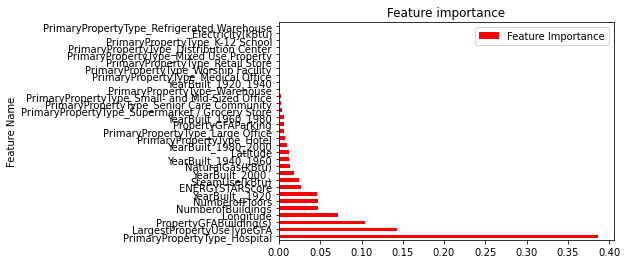

In [413]:
def display_feat_imp_xgboost(boosted):
  feat_imp = rfr_eStar.feature_importances_
  df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
  df_featimp["Feature Name"] = Xe_train.columns
  df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
  print(df_featimp)
  df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 
display_feat_imp_xgboost(rfr_eStar)

In [414]:
Xee_train, yee_train, Xee_test, yee_test = train_EStar.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']), train_EStar['TotalGHGEmissions'],test_EStar.drop(columns = ['TotalGHGEmissions','ENERGYSTARScore']) ,test_EStar['TotalGHGEmissions']

In [415]:
#CV_xgboost_EEstar = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
#CV_xgboost_EEstar.fit(Xee_train, yee_train)

In [416]:
rfr_eStar.fit(Xee_train,yee_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', random_state=12)

In [417]:
rfr_eStar.score(Xee_test,yee_test)

0.45434755979623165

### <a name='C2'> Prédictions de SiteEnergyUse(kbtu)   </a>

### - Dummy Regressor

In [418]:
CV_dummy_en = GridSearchCV(estimator=DummyRegressor(), param_grid=dummy_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_dummy_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=DummyRegressor(),
             param_grid={'strategy': ['mean', 'median']}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [419]:
CV_dummy_en.best_score_

-0.03000655841076001

In [420]:
print(f"Score - training data: {round(CV_dummy_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_dummy_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 0.0 %
Score - test data: -0.12 %


### - Random Forest

In [421]:
CV_rfr_en = GridSearchCV(estimator=RandomForestRegressor(), param_grid=rfc_param_grid, cv= 5,scoring=['r2','neg_mean_squared_error','neg_root_mean_squared_error'],refit='r2')
CV_rfr_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_root_mean_squared_error'])

In [422]:
CV_rfr_en.best_score_

0.6550712653564286

In [423]:
print(f"Score - training data: {round(CV_rfr_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_rfr_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 89.37 %
Score - test data: 84.92 %


### - Ridge Regressor

In [424]:
CV_ridge_en = GridSearchCV(estimator=Ridge(), param_grid=ridge_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_ridge_en.fit(X_train, y2_train)

GridSearchCV(cv=6, estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 2, 5, 10]}, refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [425]:
CV_ridge_en.best_score_

-0.008805671203176527

In [426]:
print(f"Score - training data: {round(CV_ridge_en.score(X_train,y2_train)*100,2)} %")
print(f"Score - test data: {round(CV_ridge_en.score(X_test,y2_test)*100,2)} %")

Score - training data: 63.42 %
Score - test data: 71.94 %


### - KNN Regressor

In [427]:
CV_knn_en = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=knn_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_knn_en.fit(X_train, y2_train)

GridSearchCV(cv=6, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
                                         20, 21, 22, 23, 24, 25, 26, 27, 28, 29,
                                         30, 31, 32, 33, 34, 35, 36, 37, 38, 39, ...]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [428]:
CV_knn_en.best_score_

0.4854593321674532

In [429]:
print(f"Score - training data: {round(CV_knn_en.score(X_train,y2_train)*100,1)} %")
print(f"Score - test data: {round(CV_knn_en.score(X_test,y2_test)*100,1)} %")

Score - training data: 44.7 %
Score - test data: 50.4 %


### - XGBoost

In [430]:
CV_xgboost_en = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid=xgboost_param_grid, cv= 5,scoring=['r2','neg_mean_absolute_error','neg_root_mean_squared_error'],refit='r2')
CV_xgboost_en.fit(X_train, y2_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 300, 400, 500],
                         'random_state': [12]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'])

In [431]:
CV_xgboost_en.best_score_

0.6776582574984114

In [432]:
CV_xgboost_en.cv_results_

{'mean_fit_time': array([0.17260442, 0.32661204, 0.5014153 , 0.67763848, 0.83037777,
        0.04553518, 0.09186616, 0.13987088, 0.17409434, 0.22238183,
        0.04569054, 0.09251037, 0.13506413, 0.17745328, 0.21935062,
        0.19971881, 0.395327  , 0.57813473, 0.80496459, 0.99659448,
        0.05267329, 0.10347462, 0.1576921 , 0.20908575, 0.26069674,
        0.05263724, 0.10498724, 0.16117997, 0.21094112, 0.2592186 ,
        0.23525791, 0.45105257, 0.65959692, 0.91540508, 1.17642198,
        0.06140718, 0.12013063, 0.17962346, 0.2485518 , 0.30497303,
        0.07798014, 0.1257534 , 0.18333101, 0.23441339, 0.29004183,
        0.26432314, 0.51462593, 0.77754965, 1.07528744, 1.3503993 ,
        0.0677259 , 0.13507028, 0.19770322, 0.27226453, 0.32741838,
        0.06629233, 0.12934804, 0.19692054, 0.26434422, 0.32668762,
        0.2967906 , 0.57554979, 0.84670343, 1.10594039, 1.39104424,
        0.0688817 , 0.13506069, 0.20560122, 0.26837726, 0.33684273,
        0.08415418, 0.13431506,

In [433]:
print(f"Score - training data: {round(CV_xgboost_en.score(X_train,y2_train)*100,1)} %")
print(f"Score - test data: {round(CV_xgboost_en.score(X_test,y2_test)*100,1)} %")

Score - training data: 99.4 %
Score - test data: 83.2 %
